**Smart Lead Scoring Engine**

Can you identify the potential leads for a D2C startup?

**Problem Statement**

A D2C startup develops products using cutting edge technologies like Web 3.0. Over the past few months, the company has started multiple marketing campaigns offline and digital both. As a result, the users have started showing interest in the product on the website. These users with intent to buy product(s) are generally known as leads (Potential Customers).

Leads are captured in 2 ways - Directly and Indirectly.

Direct leads are captured via forms embedded in the website while indirect leads are captured based on certain activity of a user on the platform such as time spent on the website, number of user sessions, etc.

Now, the marketing & sales team wants to identify the leads who are more likely to buy the product so that the sales team can manage their bandwidth efficiently by targeting these potential leads and increase the sales in a shorter span of time.

Now, as a data scientist, your task at hand is to predict the propensity to buy a product based on the user's past activities and user level information.

Variable

Description

id : Unique identifier of a lead

created_at : Date of lead dropped

signup_date: Sign up date of the user on the website

campaign_var (1 and 2) : campaign information of the lead

products_purchased : No. of past products purchased at the time of dropping the lead

useractivityvar (1 to 12): Derived activities of the user on the website

buy: 0 or 1 indicating if the user will buy the product in next 3 months or not

In [79]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold,StratifiedShuffleSplit,GroupKFold
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [2]:
# Load the dataset
train = pd.read_csv("train_wn75k28.csv")
test = pd.read_csv("test_Wf7sxXF.csv")

In [3]:
train.head()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [4]:
#Check number of rows and columns in the train and test dataset
print(f'Train shape:{train.shape}')
print(f'Test shape:{test.shape}')
#Test dataset will not contain the target variable

Train shape:(39161, 19)
Test shape:(13184, 18)


In [5]:
#Train data information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    39161 non-null  int64  
 1   created_at            39161 non-null  object 
 2   campaign_var_1        39161 non-null  int64  
 3   campaign_var_2        39161 non-null  int64  
 4   products_purchased    18250 non-null  float64
 5   signup_date           24048 non-null  object 
 6   user_activity_var_1   39161 non-null  int64  
 7   user_activity_var_2   39161 non-null  int64  
 8   user_activity_var_3   39161 non-null  int64  
 9   user_activity_var_4   39161 non-null  int64  
 10  user_activity_var_5   39161 non-null  int64  
 11  user_activity_var_6   39161 non-null  int64  
 12  user_activity_var_7   39161 non-null  int64  
 13  user_activity_var_8   39161 non-null  int64  
 14  user_activity_var_9   39161 non-null  int64  
 15  user_activity_var_1

**Most of the variables are categorical in nature eventhough it is represented in numeric form**

In [14]:
train.describe()

,id,campaign_var_1,campaign_var_2,products_purchased,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
count,39161.000000,39161.000000,39161.000000,18250.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000
mean,19581.000000,6.523812,6.452746,2.154137,0.400092,0.006716,0.102832,0.011465,0.151503,0.499834,0.286612,0.174434,0.011440,0.000383,0.218942,0.000562,0.051020
std,11304.951283,3.472944,2.614296,0.779815,0.509194,0.081676,0.303743,0.106463,0.359681,0.558166,0.455784,0.379689,0.106346,0.019568,0.431544,0.023696,0.220042
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9791.000000,4.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19581.000000,6.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29371.000000,9.000000,8.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,39161.000000,16.000000,15.000000,4.000000,3.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [6]:
# Check for percentage of missing values
train.isnull().sum()/train.shape[0] * 100

id                       0.000000
created_at               0.000000
campaign_var_1           0.000000
campaign_var_2           0.000000
products_purchased      53.397513
signup_date             38.591966
user_activity_var_1      0.000000
user_activity_var_2      0.000000
user_activity_var_3      0.000000
user_activity_var_4      0.000000
user_activity_var_5      0.000000
user_activity_var_6      0.000000
user_activity_var_7      0.000000
user_activity_var_8      0.000000
user_activity_var_9      0.000000
user_activity_var_10     0.000000
user_activity_var_11     0.000000
user_activity_var_12     0.000000
buy                      0.000000
dtype: float64

**products_purchased has 53.4 % of missing values whereas signup_date has 38.6% missing values**
**Let us see how to take care of them.**

In [4]:
train.head()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [7]:
# Percentage of Class 0(Not) and Class 1(User will buy the product)
train['buy'].value_counts(normalize=True)*100

0    94.897985
1     5.102015
Name: buy, dtype: float64

<AxesSubplot:xlabel='buy', ylabel='count'>

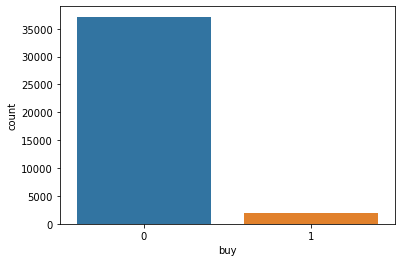

In [8]:
sns.countplot(x='buy',data=train)

**Dataset is highly imbalanced as only 5% of the records say that user buys the product.Model will not be able to predict the minority class properly if we donot take necessary steps**

**Let us look at the independent variables**

<AxesSubplot:xlabel='user_activity_var_4', ylabel='count'>

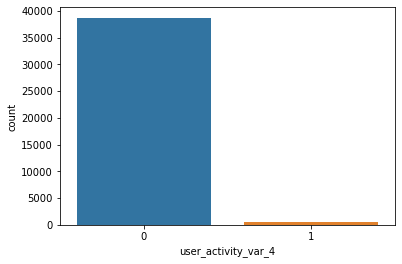

In [15]:
sns.countplot(x='user_activity_var_4',data=train)

**For products_purchased column, the reason for missing values might be products not purchased at all. So, Instead of imputing with mode or Dropping the records which will result in losing information or any other techniques,just replace missing values with 0.** 

In [17]:
#Creating a copy
train1 = train.copy()
test1 = test.copy()
dataset = [train1,test1]
for i in dataset:
    i['products_purchased'].fillna(0,inplace=True)
  

In [18]:
#Check again
train1.isnull().sum()  

id                          0
created_at                  0
campaign_var_1              0
campaign_var_2              0
products_purchased          0
signup_date             15113
user_activity_var_1         0
user_activity_var_2         0
user_activity_var_3         0
user_activity_var_4         0
user_activity_var_5         0
user_activity_var_6         0
user_activity_var_7         0
user_activity_var_8         0
user_activity_var_9         0
user_activity_var_10        0
user_activity_var_11        0
user_activity_var_12        0
buy                         0
dtype: int64

In [19]:
test1.isnull().sum()

id                         0
created_at                 0
campaign_var_1             0
campaign_var_2             0
products_purchased         0
signup_date             6649
user_activity_var_1        0
user_activity_var_2        0
user_activity_var_3        0
user_activity_var_4        0
user_activity_var_5        0
user_activity_var_6        0
user_activity_var_7        0
user_activity_var_8        0
user_activity_var_9        0
user_activity_var_10       0
user_activity_var_11       0
user_activity_var_12       0
dtype: int64

**We can check the relation between the independent variables and the target variable**

<AxesSubplot:xlabel='products_purchased'>

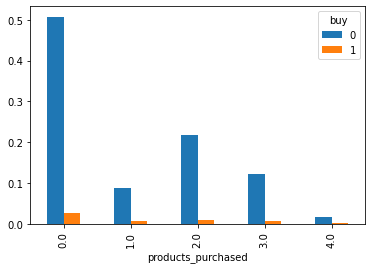

In [32]:
pd.crosstab(train1['products_purchased'], train1['buy'],normalize=True).plot(kind='bar')

In [27]:
#Check if there are unique dates
train1.created_at.value_counts()

2021-12-26    181
2021-12-09    180
2021-12-21    179
2021-12-07    179
2021-12-04    178
             ... 
2021-01-07     34
2021-01-14     33
2021-01-06     29
2021-01-22     26
2021-01-01     21
Name: created_at, Length: 365, dtype: int64

<AxesSubplot:xlabel='campaign_var_1'>

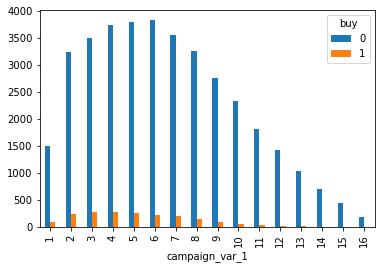

In [31]:
pd.crosstab(train1['campaign_var_1'], train1['buy'],margins=False).plot(kind='bar')

<AxesSubplot:xlabel='campaign_var_2'>

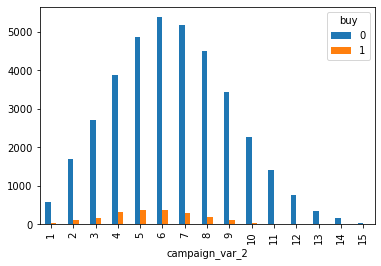

In [33]:
pd.crosstab(train1['campaign_var_2'], train1['buy'],margins=False).plot(kind='bar')

In [35]:
train1['signup_date']

0        2020-09-24
1        2020-09-19
2        2021-08-11
3        2017-10-04
4        2020-06-08
            ...    
39156    2017-10-19
39157           NaN
39158           NaN
39159           NaN
39160    2019-08-11
Name: signup_date, Length: 39161, dtype: object

**There are missing values in the signup_date column.It can be imputed with mode or using ffill or bfill method.
Here,I have used bfill for train data and ffill for test data**

In [36]:
train1['signup_date'].bfill(inplace=True)

In [39]:
test1['signup_date'].ffill(inplace=True)

In [40]:
#Check again as there are chances the missing values still present if using bfill or ffill.
test1.isnull().sum()

id                      0
created_at              0
campaign_var_1          0
campaign_var_2          0
products_purchased      0
signup_date             0
user_activity_var_1     0
user_activity_var_2     0
user_activity_var_3     0
user_activity_var_4     0
user_activity_var_5     0
user_activity_var_6     0
user_activity_var_7     0
user_activity_var_8     0
user_activity_var_9     0
user_activity_var_10    0
user_activity_var_11    0
user_activity_var_12    0
dtype: int64

In [41]:
train1.isnull().sum()

id                      0
created_at              0
campaign_var_1          0
campaign_var_2          0
products_purchased      0
signup_date             0
user_activity_var_1     0
user_activity_var_2     0
user_activity_var_3     0
user_activity_var_4     0
user_activity_var_5     0
user_activity_var_6     0
user_activity_var_7     0
user_activity_var_8     0
user_activity_var_9     0
user_activity_var_10    0
user_activity_var_11    0
user_activity_var_12    0
buy                     0
dtype: int64

In [42]:
dataset=[train1,test1]
for i in dataset:
    i['created_at'] = pd.to_datetime(i['created_at'])
    i['signup_date']= pd.to_datetime(i['signup_date'])

In [43]:
#check if converted to datetime format
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    39161 non-null  int64         
 1   created_at            39161 non-null  datetime64[ns]
 2   campaign_var_1        39161 non-null  int64         
 3   campaign_var_2        39161 non-null  int64         
 4   products_purchased    39161 non-null  float64       
 5   signup_date           39161 non-null  datetime64[ns]
 6   user_activity_var_1   39161 non-null  int64         
 7   user_activity_var_2   39161 non-null  int64         
 8   user_activity_var_3   39161 non-null  int64         
 9   user_activity_var_4   39161 non-null  int64         
 10  user_activity_var_5   39161 non-null  int64         
 11  user_activity_var_6   39161 non-null  int64         
 12  user_activity_var_7   39161 non-null  int64         
 13  user_activity_va

In [44]:
dataset=[train1,test1]
for i in dataset:
    i['created_at_day'] = i['created_at'].dt.day
    i['created_at_month'] = i['created_at'].dt.month
    i['signup_date_year'] = i['signup_date'].dt.year
    i['signup_date_month'] = i['signup_date'].dt.month
    i['signup_date_day'] = i['signup_date'].dt.day

In [45]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    39161 non-null  int64         
 1   created_at            39161 non-null  datetime64[ns]
 2   campaign_var_1        39161 non-null  int64         
 3   campaign_var_2        39161 non-null  int64         
 4   products_purchased    39161 non-null  float64       
 5   signup_date           39161 non-null  datetime64[ns]
 6   user_activity_var_1   39161 non-null  int64         
 7   user_activity_var_2   39161 non-null  int64         
 8   user_activity_var_3   39161 non-null  int64         
 9   user_activity_var_4   39161 non-null  int64         
 10  user_activity_var_5   39161 non-null  int64         
 11  user_activity_var_6   39161 non-null  int64         
 12  user_activity_var_7   39161 non-null  int64         
 13  user_activity_va

In [46]:
#Drop the signup_date and created_at columns as they are not needed anymore
dataset=[train1,test1]
for i in dataset:
     i.drop(columns=['signup_date','created_at'],inplace=True)

In [47]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    39161 non-null  int64  
 1   campaign_var_1        39161 non-null  int64  
 2   campaign_var_2        39161 non-null  int64  
 3   products_purchased    39161 non-null  float64
 4   user_activity_var_1   39161 non-null  int64  
 5   user_activity_var_2   39161 non-null  int64  
 6   user_activity_var_3   39161 non-null  int64  
 7   user_activity_var_4   39161 non-null  int64  
 8   user_activity_var_5   39161 non-null  int64  
 9   user_activity_var_6   39161 non-null  int64  
 10  user_activity_var_7   39161 non-null  int64  
 11  user_activity_var_8   39161 non-null  int64  
 12  user_activity_var_9   39161 non-null  int64  
 13  user_activity_var_10  39161 non-null  int64  
 14  user_activity_var_11  39161 non-null  int64  
 15  user_activity_var_1

In [50]:
#Change products_purchased to int
dataset=[train1,test1]
for i in dataset:
    i['products_purchased'] = i['products_purchased'].astype('int64')

In [51]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   id                    39161 non-null  int64
 1   campaign_var_1        39161 non-null  int64
 2   campaign_var_2        39161 non-null  int64
 3   products_purchased    39161 non-null  int64
 4   user_activity_var_1   39161 non-null  int64
 5   user_activity_var_2   39161 non-null  int64
 6   user_activity_var_3   39161 non-null  int64
 7   user_activity_var_4   39161 non-null  int64
 8   user_activity_var_5   39161 non-null  int64
 9   user_activity_var_6   39161 non-null  int64
 10  user_activity_var_7   39161 non-null  int64
 11  user_activity_var_8   39161 non-null  int64
 12  user_activity_var_9   39161 non-null  int64
 13  user_activity_var_10  39161 non-null  int64
 14  user_activity_var_11  39161 non-null  int64
 15  user_activity_var_12  39161 non-null  int64
 16  buy 

In [52]:
#Split into X(independent features) and y(target variable)
#Drop id variable as it doesnot help in prediction
X = train1.drop(columns=['id','buy'],axis=1)
y = train1['buy']

In [53]:
#Even in test data remove id column
dftest1 = test1.drop('id',axis=1)

In [54]:
#Apply standardscaler method
sc = StandardScaler()
for col in X.columns:
    X[col] = sc.fit_transform(X[col].values.reshape(-1,1))

In [55]:
for col in dftest1.columns:
    dftest1[col] = sc.fit_transform(dftest1[col].values.reshape(-1,1))

**Have tried the following methods**

- Split into train and test with stratify=y
- Tried SMOTE on train data
- Compared the classifiers - DecisionTree Classifier,RandomForest Classifier,XGBoost,CatBoost and lightGBM
- Also applied hyperparameter tuning - GridsearchCV and RandomizedSearchCV
- Compared StratifiedKFold,RepeatedStratifiedKFold,StratifiedShuffleSplit with splits-10 -Not much difference in the results
- Finally Stratified K fold sampling with Random Forest classifier model along with certain hyperparameters gave the best result

In [83]:
skf = StratifiedShuffleSplit(n_splits=10)
model = RandomForestClassifier(max_depth=14, max_features='log2', n_estimators=41)
def training(train, test, fold_no):
    x_train = train.drop(['id','buy'],axis=1)
    y_train = train.buy
    x_test = test.drop(['id','buy'],axis=1)
    y_test = test.buy
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = model.score(x_test,y_test)
    print('For Fold {} the accuracy is {}'.format(str(fold_no),score))
    print(f'f1 score is {f1_score(y_test,y_pred)}')

In [74]:
fold_no = 1
for train_index,test_index in skf.split(X, y):
    train = train1.iloc[train_index,:]
    test = train1.iloc[test_index,:]
    training(train, test, fold_no)
    fold_no += 1


For Fold 1 the accuracy is 0.9767679346438601
f1 score is 0.7129337539432177
For Fold 2 the accuracy is 0.9757467449578759
f1 score is 0.6964856230031949
For Fold 3 the accuracy is 0.9780444217513403
f1 score is 0.7345679012345679
For Fold 4 the accuracy is 0.976512637222364
f1 score is 0.7051282051282052
For Fold 5 the accuracy is 0.9721725810569313
f1 score is 0.6378737541528239
For Fold 6 the accuracy is 0.9770232320653561
f1 score is 0.7169811320754716
For Fold 7 the accuracy is 0.976512637222364
f1 score is 0.7088607594936709
For Fold 8 the accuracy is 0.9770232320653561
f1 score is 0.7204968944099378
For Fold 9 the accuracy is 0.976257339800868
f1 score is 0.7028753993610224
For Fold 10 the accuracy is 0.9742149604288997
f1 score is 0.6731391585760519


In [75]:
target = model.predict(dftest1)
target

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [76]:
test1.columns

Index(['id', 'campaign_var_1', 'campaign_var_2', 'products_purchased',
       'user_activity_var_1', 'user_activity_var_2', 'user_activity_var_3',
       'user_activity_var_4', 'user_activity_var_5', 'user_activity_var_6',
       'user_activity_var_7', 'user_activity_var_8', 'user_activity_var_9',
       'user_activity_var_10', 'user_activity_var_11', 'user_activity_var_12',
       'created_at_day', 'created_at_month', 'signup_date_year',
       'signup_date_month', 'signup_date_day'],
      dtype='object')

In [77]:
res = pd.DataFrame(target) #the final predictions of model on input features of new unseen test data
res.index = test1.id # its important for comparison. Here "new_test_data" is the new test dataset
res.columns = ["buy"]
res.to_csv("prediction.csv") 

In [ ]:
#end of notebook